This notebook provides some example cases for using EIF. Three cases of single blob, multiple blobs, and sinusoidal data that are presented in the paper are used here for this demo. In each case we compare the standard Isolation Forest with the Extended Isolation Forest using the eif package. The eif package can easily be installed using pip as follows:

pip install eif

Various plots such as scatter plots, score distributions, score maps, and tree and forest visualizations are presented. This notebook is meant to demonstrate how to use the basic functionality of eif. For the details of how the algorithm works, see the paper(s) referenced in the repository. 

# Imports

While the core package only needs numpy, we make use of other packages in creating our test functions below, mostly for visualization or data generation. They are not however, necessary for the algorithm to run. Feel free to use any other package you like. 

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import seaborn as sb
import eif

sb.set_style(style="whitegrid")
sb.set_color_codes()
from scipy.special import softmax
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import sys

sys.path.append("..")
import sif
# import eif_old as eif

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, load_iris, load_digits
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# Utility Functions

These utility functions are used in creating the radial plots below. We use these two functions to find the depth (not anomaly score) a given data point reaches in an Isolation Forest tree. 

In [28]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == "exNode":
        return d
    else:
        if (x - p).dot(n) < 0:
            return getDepth(x, root.left, d + 1)
        else:
            return getDepth(x, root.right, d + 1)

def getVals(forest, x, sorted=True):
    theta = np.linspace(0, 2 * np.pi, forest.ntrees)
    r = []
    for i in range(forest.ntrees):
        temp = forest.compute_paths_single_tree(np.array([x]), i)
        r.append(temp[0])
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

# Construct Datasets

In [48]:
def construct_datasets(n_samples):
    X, y = make_classification(
        n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)
    
    guassian_one = rng.normal(5, 1, (n_samples, 10))
    guassian_two = rng.normal(-5, 1, (n_samples, 10))
    X = np.concatenate((guassian_one, guassian_two))
    y = np.concatenate(([0] * n_samples, [1] * n_samples))
    ind_high_dim_guassian = (X, y)
    
    
    centers = [(-5, -5), (5, 5)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
    y[: n_samples // 2] = 0
    y[n_samples // 2 :] = 1
    separated_blobs = (X, y)
    
    
    centers = [(1, 1), (1, 3)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
    y[: n_samples // 2] = 0
    y[n_samples // 2 :] = 1
    overlapping_blobs = (X, y)
    

    iris = load_iris()
    X, y = iris.data[:, :2], iris.target  # we only take the first two features.
    iris_first_two_feats = (X, y)
    
    
    X, y = load_digits(return_X_y=True)
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=42))
    X = pca.fit_transform(X)
    pca_mnist = (X, y)
    
    return [
        make_moons(n_samples=n_samples, noise=0.1, random_state=42),
        make_circles(n_samples=n_samples, noise=0.1, factor=0.8, random_state=42),
        linearly_separable,
        separated_blobs,
        overlapping_blobs,
        iris_first_two_feats,
        pca_mnist
    ]

datasets = construct_datasets(512)
names = ['moons', 'circles', 'linearly_separable', 'separated_blobs', 'overlapping_blobs', 'iris_first_two_feats', 'pca_mnist']

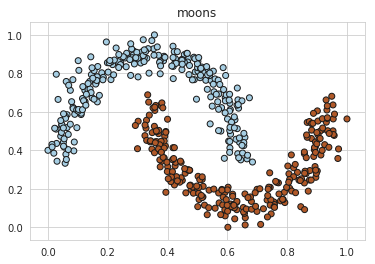

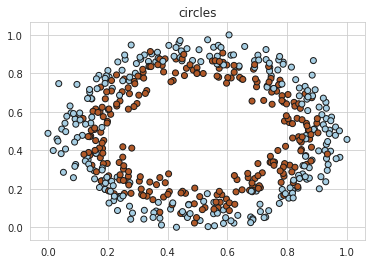

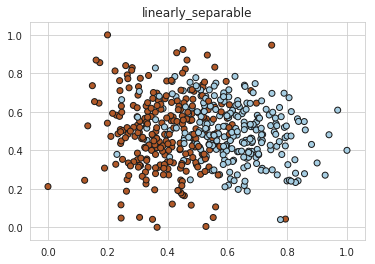

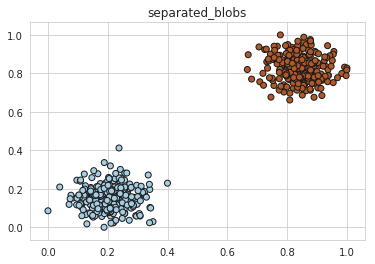

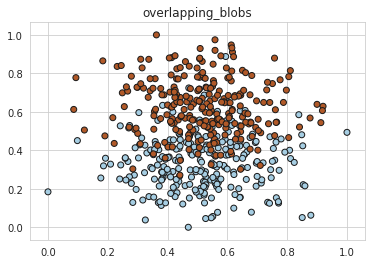

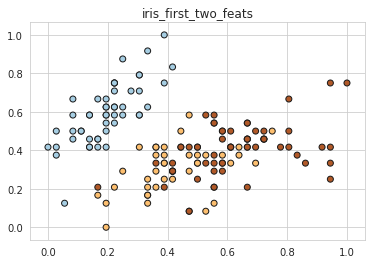

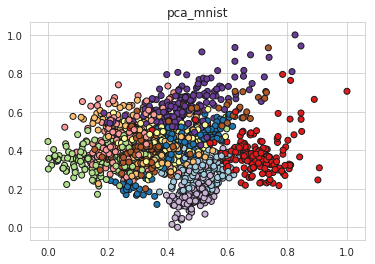

In [49]:
for name, ds in zip(names, datasets):
    X, y = ds
    # Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
    X = MinMaxScaler().fit_transform(X)

    plt.title(name)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
    plt.show();

In [50]:
def plot_sif(ds, name, n_trees=500, el=0, scatter=True):
    X, y = ds
    X = MinMaxScaler().fit_transform(X)

    x1, x2 = X[:, 0], X[:, 1]
    xlim_low, xlim_high = min(x1), max(x1)
    ylim_low, ylim_high = min(x2), max(x2)
    xx, yy = np.meshgrid(np.linspace(xlim_low, xlim_high, 30), np.linspace(ylim_low, ylim_high, 30))
    
    sample_size = min(256, int(0.5 * len(X)))

    F0 = eif.iForest(X, ntrees=n_trees, sample_size=sample_size, ExtensionLevel=el)
    S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    S0 = S0.reshape(xx.shape)

    F1 = sif.iForest(X, y, ntrees=n_trees, sample_size=sample_size, ExtensionLevel=el)
    F1.fit(X, y)
    S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    S1 = S1.reshape(xx.shape)
    
    S0 = np.log2(S0) * -F1.c # undo anomaly score calc
    S1 = np.log2(S1)* -F1.c # undo anomaly score calc
    
    f = plt.figure(figsize=(10, 10))
    
#     S1 = np.max(S1) - S1
#     S1 = -S1


    ########################
    ### DEPTH HEAT MAP
    #########################
    ax1 = f.add_subplot(222)
    levels = np.linspace(np.min(S0), np.max(S0), 10)
    CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.viridis)
    if scatter:
        plt.scatter(x1, x2, s=15, c=y, edgecolor="k")
#     plt.axis("equal")
    plt.title("standard IF\ntree depth map")
    plt.colorbar(CS, ax=ax1)
    ax1.set_ylim(ylim_low, ylim_high)
    ax1.set_xlim(xlim_low, xlim_high)
    
    
    ax2 = f.add_subplot(224)
    levels = np.linspace(np.min(S1), np.max(S0), 10)

    CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.viridis)
    if scatter:
        plt.scatter(x1, x2, s=15, c=y, edgecolor="k")
#     plt.axis("equal")
    plt.title(f"supervised IF\ntree depth map")
    plt.colorbar(CS, ax=ax2)
    ax2.set_ylim(ylim_low, ylim_high)
    ax2.set_xlim(xlim_low, xlim_high)

    ########################
    ### DEPTH HISTOGRAM
    #########################
    
    S0 = F0.compute_paths(X_in=X)
    S0 = np.log2(S0) * -F1.c # undo anomaly score calc

    S1 = F1.compute_paths(X_in=X)
    S1 = np.log2(S1)* -F1.c # undo anomaly score calc

    
    ax5 = f.add_subplot(221)
    ax5.hist(S0)
    ax5.set_title(
        "standard IF, average depth of point in forest\nMean={0:.2f}, Var={1:.2f}.".format(np.mean(S0), np.var(S0))
    )

    ax6 = f.add_subplot(223, sharex=ax5)
    ax6.hist(S1)
    ax6.set_title(
        "supervised IF, average depth of point in forest\nMean={0:.2f}, Var={1:.2f}.".format(np.mean(S1), np.var(S1))
    )
    f.suptitle(name, fontsize=16)
    plt.show()
    
    return F1.Trees

In [51]:
to_test = ['separated_blobs', 'overlapping_blobs']
to_test = names

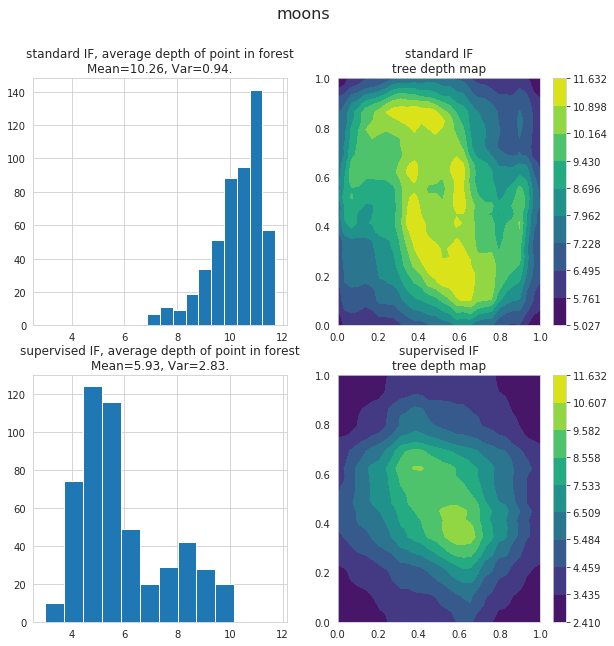

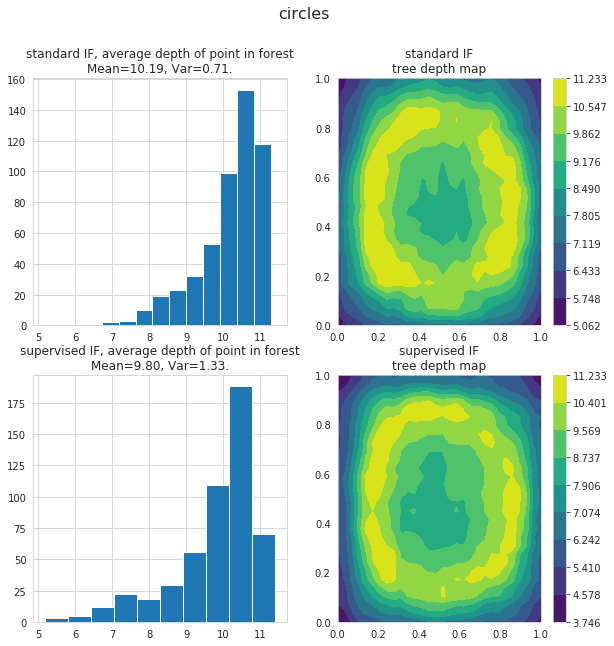

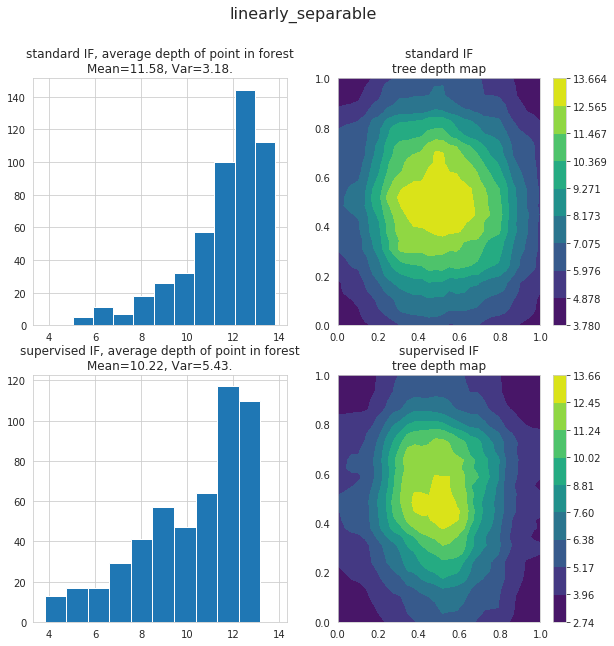

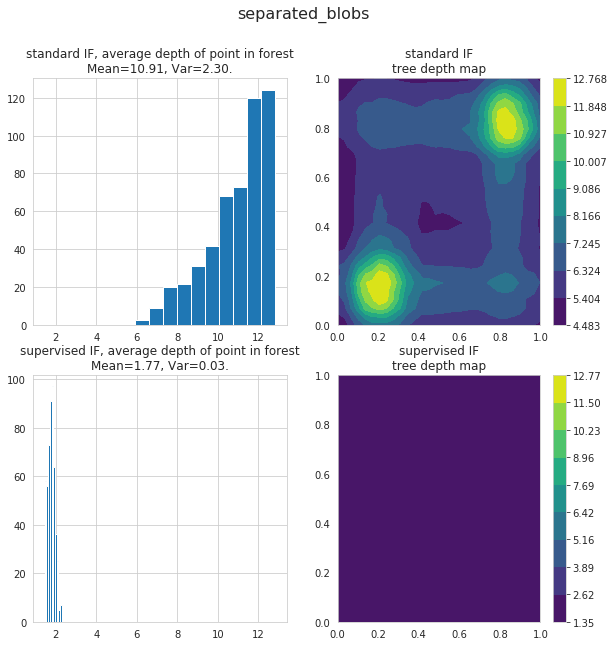

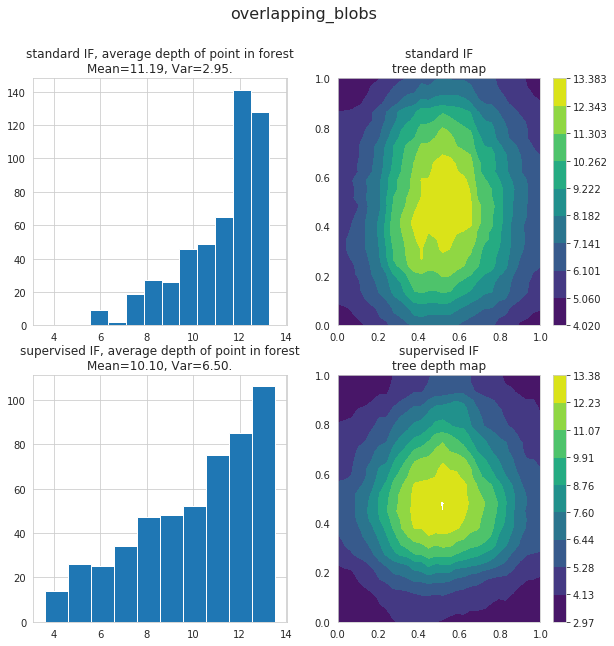

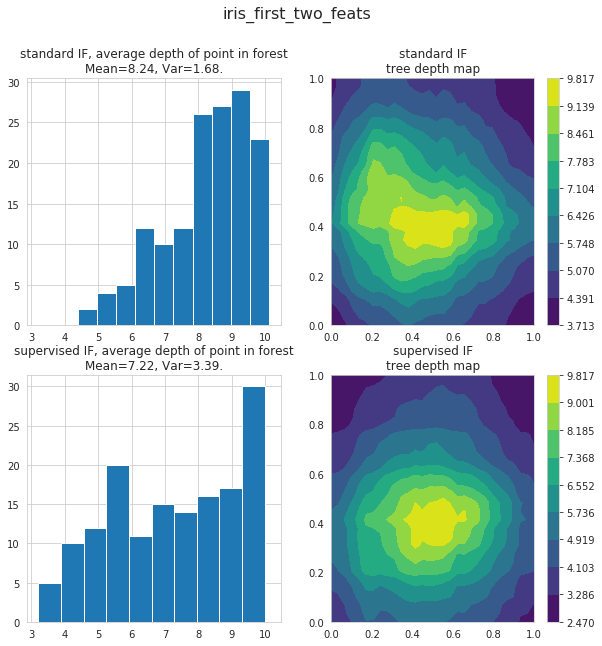

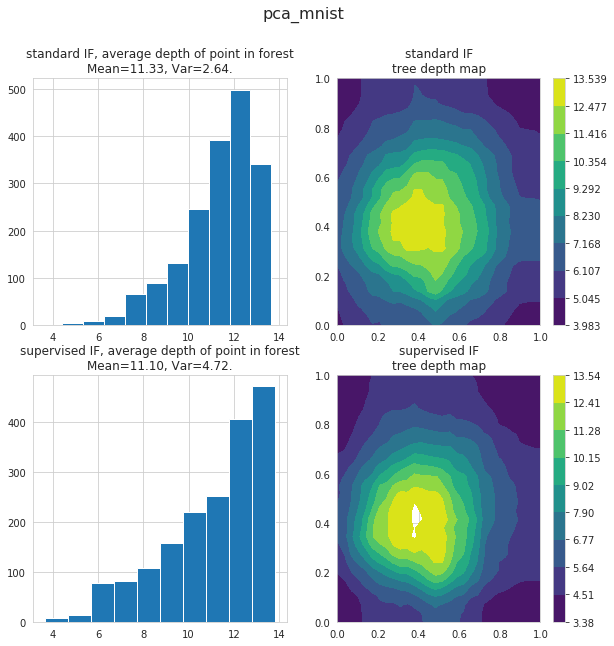

In [52]:
for name, ds in zip(names, datasets):
    if name in to_test:
        trees = plot_sif(ds, name, n_trees=100, el=0, scatter=False)

In [22]:
# print(trees[0])
x = np.arange(10)

In [14]:
def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '->', 'node.n, node.p')
        printTree(node.right, level + 1)

In [15]:
printTree(trees[0].root)

        -> node.n, node.p
    -> node.n, node.p
            -> node.n, node.p
        -> node.n, node.p
                        -> node.n, node.p
                    -> node.n, node.p
                            -> node.n, node.p
                        -> node.n, node.p
                            -> node.n, node.p
                -> node.n, node.p
                            -> node.n, node.p
                        -> node.n, node.p
                            -> node.n, node.p
                    -> node.n, node.p
                        -> node.n, node.p
            -> node.n, node.p
                            -> node.n, node.p
                        -> node.n, node.p
                            -> node.n, node.p
                    -> node.n, node.p
                            -> node.n, node.p
                        -> node.n, node.p
                            -> node.n, node.p
                -> node.n, node.p
                            -> node.n, node.p
                  